Licensed under the MIT License.

Copyright (c) 2021-2025. All rights reserved.

# Optuna Specified Search Space

* Optuna prunning algorithms: https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/003_efficient_optimization_algorithms.html#pruning-algorithms

In [1]:
import pandas as pd
import timeit

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn import preprocessing

import lightgbm as lgb
from lightgbm import LGBMRegressor
import optuna

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/sales.pkl')

# train, test split for df
train_df = df.loc[df['Year'].astype(str) < '2015']
test_df = df.loc[df['Year'].astype(str) == '2015']

y_train, y_test = train_df['Sales'], test_df['Sales']
X_train, X_test = train_df.drop(['Sales', 'Date', 'Year'], axis=1), test_df.drop(['Sales', 'Date', 'Year'], axis=1)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train.head()

(532529, 18) (161332, 18) (532529,) (161332,)


,Store,Month,Quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,12,4,2,0,1270.0,9,2008,0,-1,-1,-1,3,327,1,0,0,1
1,1,12,4,2,0,1270.0,9,2008,0,-1,-1,-1,2,703,1,0,0,1
2,1,12,4,2,0,1270.0,9,2008,0,-1,-1,-1,1,700,1,0,0,1
3,1,12,4,2,0,1270.0,9,2008,0,-1,-1,-1,7,0,0,0,0,1
4,1,12,4,2,0,1270.0,9,2008,0,-1,-1,-1,6,684,1,0,0,1


## For Leaves30

In [3]:
def objective(trial):
    dtrain = lgb.Dataset(X_train, y_train)
    dval = lgb.Dataset(X_test, y_test)
    upper = min(32768, int(X_train.shape[0]))
        
    params = {
        "objective": "regression",
        "metric": "mape",
        "random_state": 10,
        "verbosity": -1,
        
        # specify the similar search space as FLAML, but optuna has no initial value to suggest
        "num_leaves": trial.suggest_int("num_leaves", 4, upper),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1/1024, 1.0),
        "subsample": trial.suggest_uniform("subsample", 0.1, 1.0),
        "max_bin": trial.suggest_int("max_bin", 3, 10),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.01, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1/1024, 1024),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1/1024, 1024),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "extra_trees": True
    }
    
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "mape")
    clf = lgb.train(
        params, dtrain, valid_sets=[dval], verbose_eval=False, callbacks=[pruning_callback]
    )

    y_pred = clf.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return mape

In [4]:
start = timeit.default_timer()

study = optuna.create_study(direction="minimize", pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=180)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
stop = timeit.default_timer()
print('Time: ', stop - start)

[I 2021-09-04 22:10:16,214] A new study created in memory with name: no-name-e083afb3-1592-4afb-9df3-6ebdb17803fa
[I 2021-09-04 22:10:26,283] Trial 0 finished with value: 1.7117832331907008e+17 and parameters: {'num_leaves': 16658, 'learning_rate': 0.38418484570659567, 'subsample': 0.656242476193716, 'max_bin': 7, 'colsample_bytree': 0.3490742100916358, 'reg_alpha': 0.002106404706520766, 'reg_lambda': 4.908978363940727, 'max_depth': 10}. Best is trial 0 with value: 1.7117832331907008e+17.
[I 2021-09-04 22:10:31,371] Trial 1 finished with value: 1.9431207279083024e+17 and parameters: {'num_leaves': 25416, 'learning_rate': 0.5385852501816885, 'subsample': 0.2614045147721976, 'max_bin': 8, 'colsample_bytree': 0.3771294221196161, 'reg_alpha': 0.015564012323944814, 'reg_lambda': 0.013871801909216068, 'max_depth': 4}. Best is trial 0 with value: 1.7117832331907008e+17.
[I 2021-09-04 22:10:32,787] Trial 2 pruned. Trial was pruned at iteration 3.
[I 2021-09-04 22:10:39,335] Trial 3 finished wi

Number of finished trials: 180
Best trial:
  Value: 3.0080394683864452e+16
  Params: 
    num_leaves: 24536
    learning_rate: 0.26395666956334923
    subsample: 0.15992329108513492
    max_bin: 8
    colsample_bytree: 0.9922451397332521
    reg_alpha: 22.905971159598263
    reg_lambda: 0.09975918661295301
    max_depth: 7
Time:  461.2881876


In [18]:
turned_params= {
    'num_leaves': trial.params['num_leaves'],
    'learning_rate': trial.params['learning_rate'],
    'subsample': trial.params['subsample'],
    'max_bin': trial.params['max_bin'],
    'colsample_bytree': trial.params['colsample_bytree'],
    'reg_alpha': trial.params['reg_alpha'],
    'reg_lambda': trial.params['reg_lambda'],
    'max_depth': trial.params['max_depth']
}

model = LGBMRegressor(objective='regression', metric='mape',
                       random_state=10, **turned_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f'Testing R2 is {r2}')

Testing R2 is 0.9636877688547115


### Optuna Visualization

* Optuna supported visualization list: https://optuna.readthedocs.io/en/stable/reference/visualization/index.html
* Installation list needed if you're using jupyter: https://github.com/plotly/plotly.py#installation

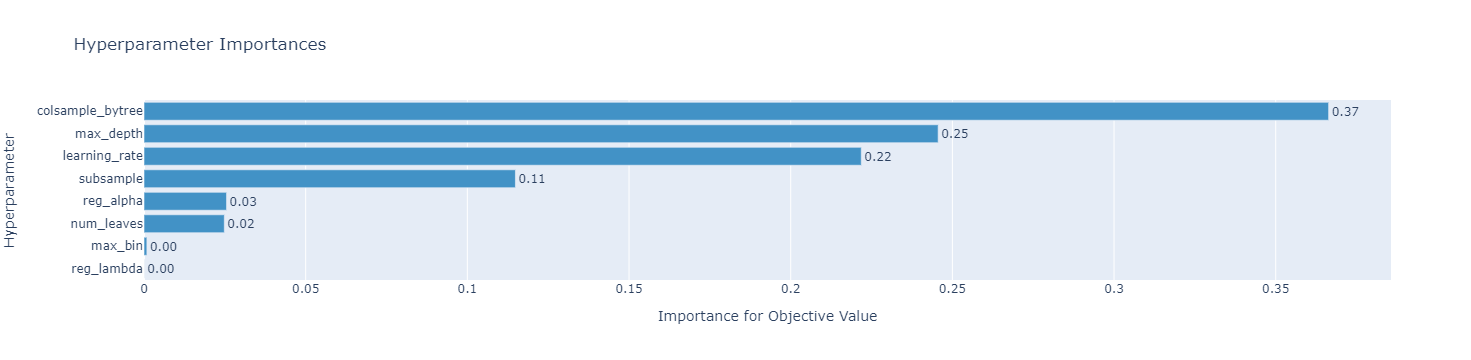

In [14]:
optuna.visualization.plot_param_importances(study)

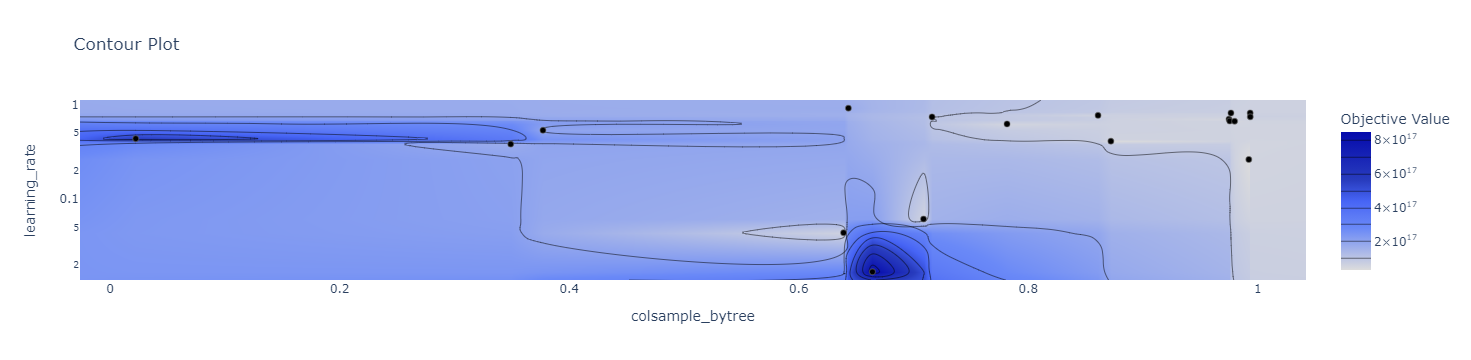

In [15]:
optuna.visualization.plot_contour(study, params=['colsample_bytree', 'learning_rate'])

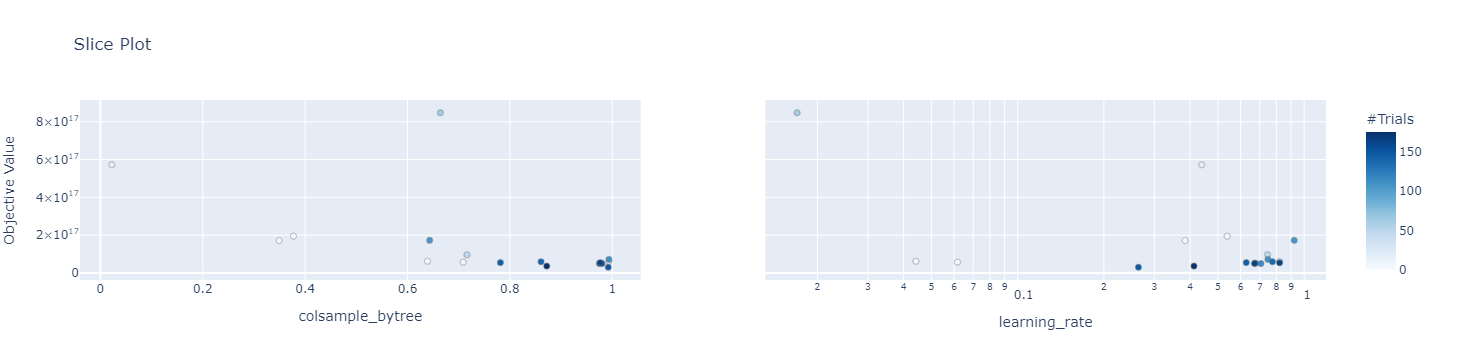

In [17]:
optuna.visualization.plot_slice(study, params=['colsample_bytree', 'learning_rate'])

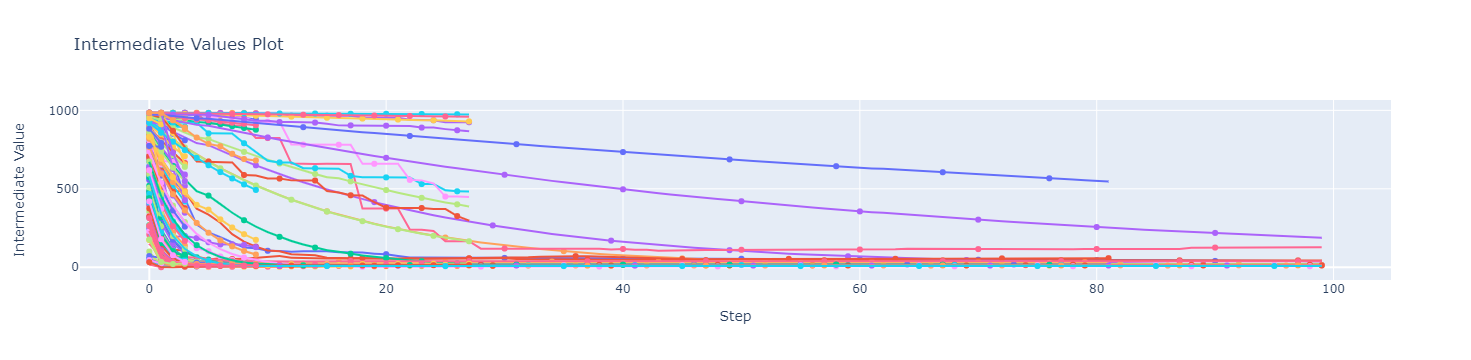

In [19]:
optuna.visualization.plot_intermediate_values(study)

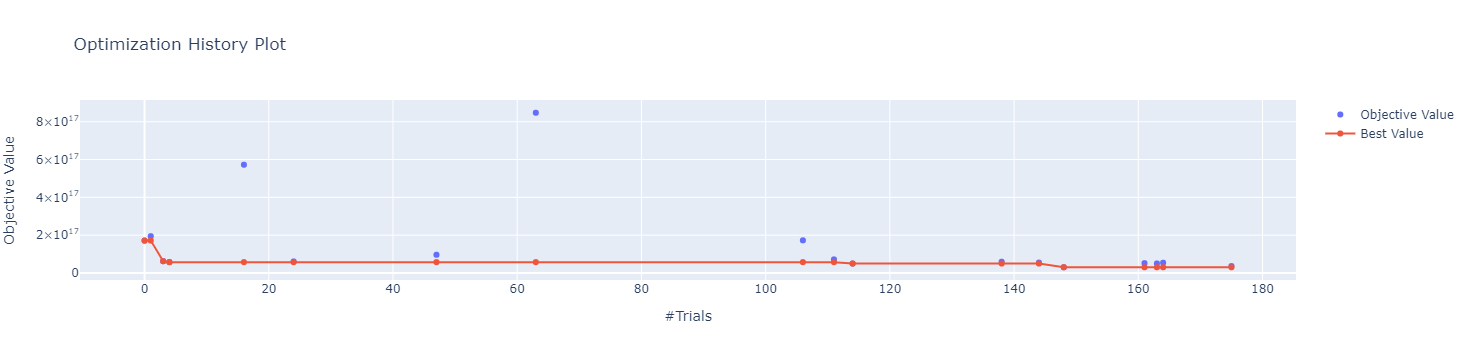

In [11]:
optuna.visualization.plot_optimization_history(study)